Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 12
sigma_ = sigma/255.

In [2]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

fname = 'data/fake/circle_10_at_20_20.png'
fname2 = 'data/fake/circle_10_at_40_40.png'

# Load image

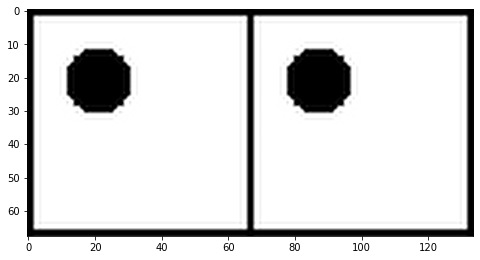

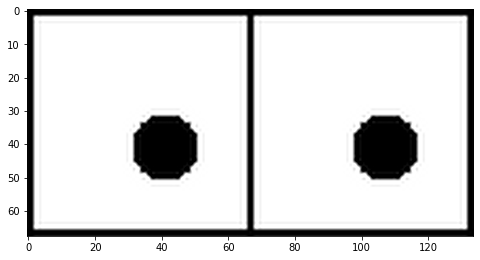

In [3]:
import imutils
import cv2

def create_2nd_imgs(img):
    img_np2 = img
    img_np2 = img_np2.transpose(1, 2, 0)
    
    
    # ROTATE ENLARGE and CROP down.
    img_npr = imutils.rotate(img_np2, 10)
    new_size = (int(img_npr.shape[0] * 1.1), int(img_npr.shape[1] * 1.1))
    img_npr = cv2.resize(img_npr, new_size)
    
    diff_size2 = int((new_size[0] - img_np2.shape[0]) / 2)
    
    img_npr = img_npr[diff_size2 : (new_size[0] - diff_size2), diff_size2 : (new_size[1] - diff_size2)]
    
    img_np2 = img_npr.transpose(2, 0, 1)    
    img_np2 = pil_to_np(crop_image(np_to_pil(img_np2), d = 32))
    img_pil2 = np_to_pil(img_np2)

    img_noisy_pil2, img_noisy_np2 = get_noisy_image(img_np2, sigma_)
    
    return img_np2, img_pil2, img_noisy_np2, img_noisy_pil2



if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        
elif fname == 'data/denoising/F16_GT.png':
    #For testing purpose. resize the image to half
    imsize = (256, 256);
    
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)

    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    # Create 2nd image
    img_np2, img_pil2, img_noisy_np2, img_noisy_pil2 = create_2nd_imgs(img_np)
    
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
        plot_image_grid([img_np2, img_noisy_np2], 4, 6);
elif fname == 'data/fake/circle_10_at_20_20.png':
        #For testing purpose. resize the image to half
    imsize = (64, 64);
    
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, 0)

    img_pil2 = crop_image(get_image(fname2, imsize)[0], d=32)
    img_np2 = pil_to_np(img_pil2)
    img_noisy_pil2, img_noisy_np2 = get_noisy_image(img_np2, 0)
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
        plot_image_grid([img_np2, img_noisy_np2], 4, 6);
    
else:
    assert False

# Setup

In [4]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    #num_iter = 3000
    
    num_iter = 2000
    
    #input_depth = 32 
    input_depth = 16
    figsize = 4 
    
    
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)
    
elif fname == 'data/fake/circle_10_at_20_20.png':
    num_iter = 800
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')
    
    net = net.type(dtype)

else:
    assert False
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

img_noisy_torch2 = np_to_torch(img_noisy_np2).type(dtype)

DIM:  1
DIM:  1
Number of params: 572827


# Optimize

Starting optimization with ADAM


/home/jyutsehchi/.local/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/jyutsehchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/jyutsehchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/jyutsehchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: DEPRECATED: skimage.measure.comp

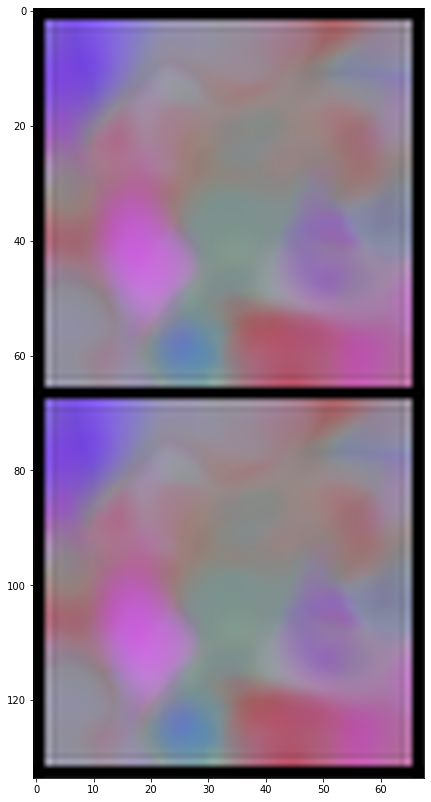

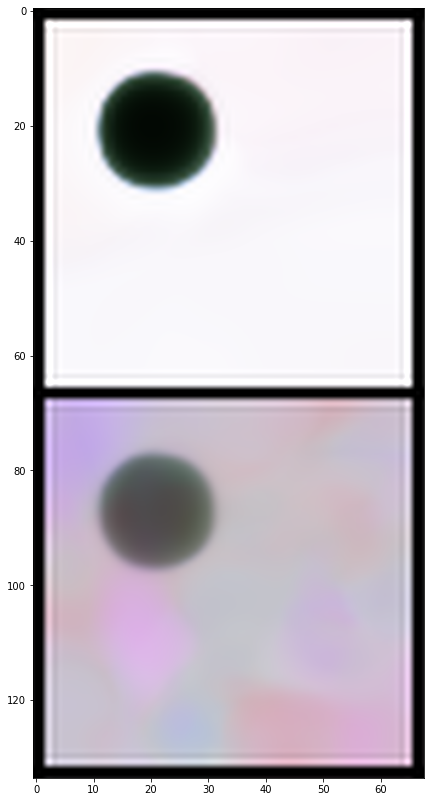

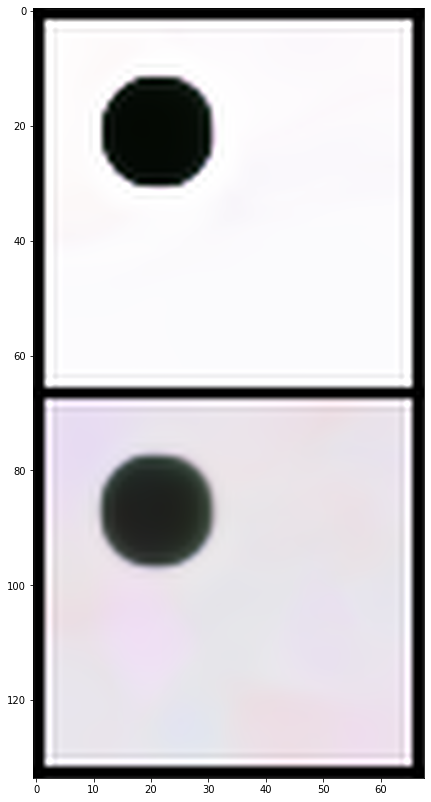

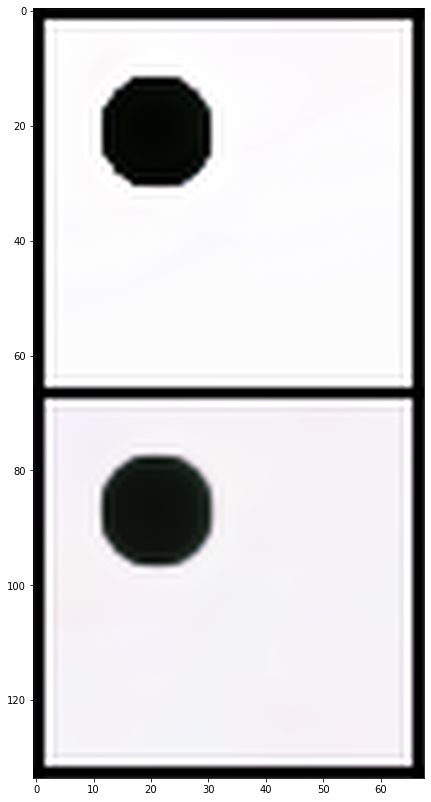

Falling back to previous checkpoint.SNR_noisy: 27.765513   PSRN_gt: 27.765513 PSNR_gt_sm: 27.276298 
Falling back to previous checkpoint.SNR_noisy: 25.365774   PSRN_gt: 25.365774 PSNR_gt_sm: 27.301286 
Falling back to previous checkpoint.SNR_noisy: 21.790611   PSRN_gt: 21.790611 PSNR_gt_sm: 27.301754 
Falling back to previous checkpoint.SNR_noisy: 24.725117   PSRN_gt: 24.725117 PSNR_gt_sm: 27.324410 
Falling back to previous checkpoint.SNR_noisy: 24.876769   PSRN_gt: 24.876769 PSNR_gt_sm: 27.345097 
Falling back to previous checkpoint.SNR_noisy: 23.981535   PSRN_gt: 23.981535 PSNR_gt_sm: 27.362685 
Falling back to previous checkpoint.SNR_noisy: 22.024236   PSRN_gt: 22.024236 PSNR_gt_sm: 27.361809 
Falling back to previous checkpoint.SNR_noisy: 22.151951   PSRN_gt: 22.151951 PSNR_gt_sm: 27.364709 
Falling back to previous checkpoint.SNR_noisy: 22.855227   PSRN_gt: 22.855227 PSNR_gt_sm: 27.369977 
Falling back to previous checkpoint.SNR_noisy: 23.748348   PSRN_gt: 23.748348 PSNR_gt_sm: 2

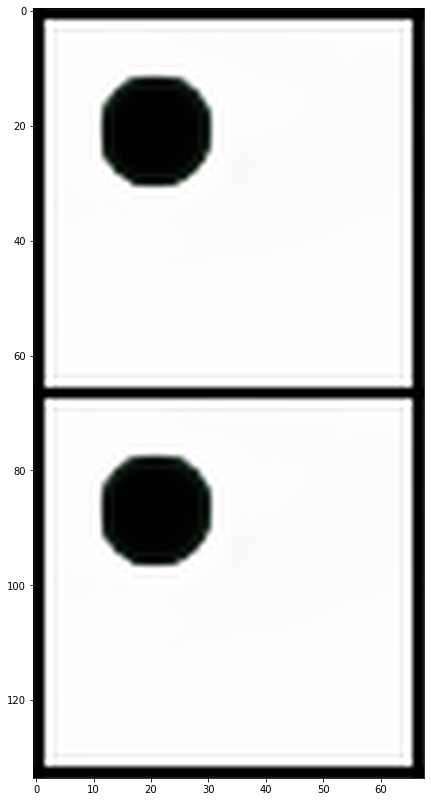

/home/jyutsehchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/jyutsehchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/jyutsehchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


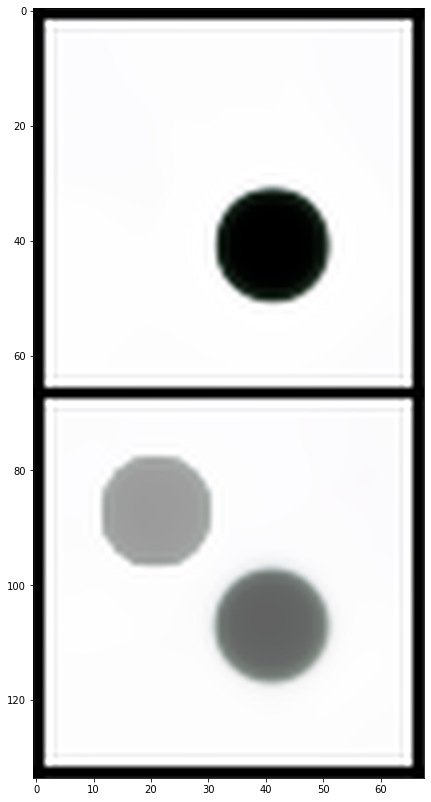

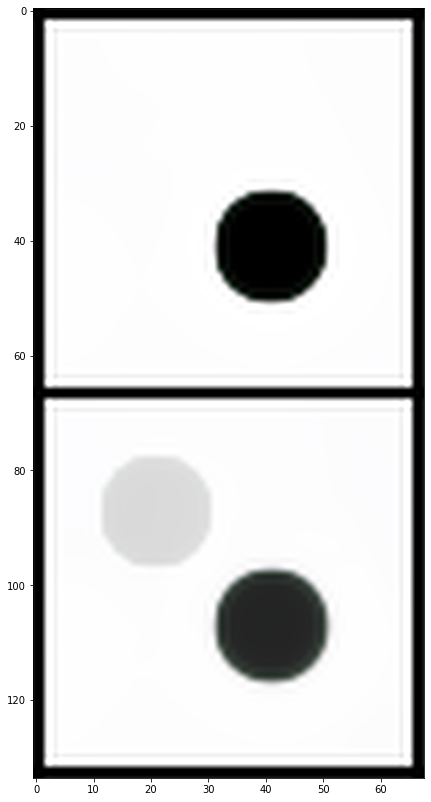

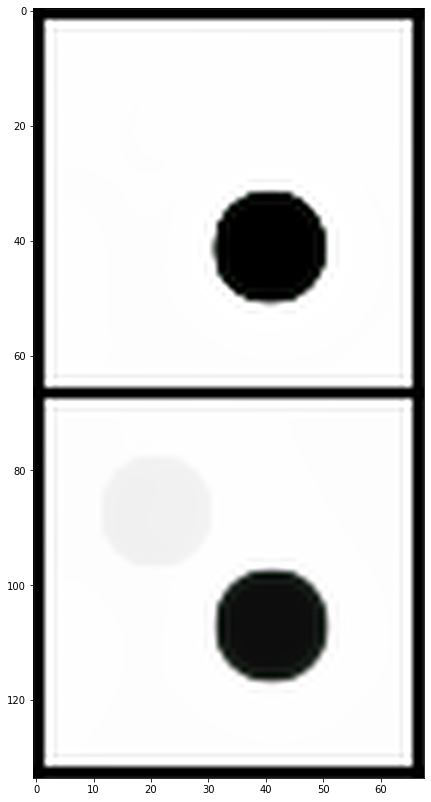

In [99]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

out_avg = None
out_avg2 = None
last_net = None
psrn_noisy_last = 0

first_img_iter = int(num_iter / 2);

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input, out_avg2
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    if i == first_img_iter:
        out_avg = None
        psrn_noisy_last = 0
    
    # Smoothing
    if out_avg is None or i == first_img_iter+1:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    if i <= first_img_iter:
        total_loss = mse(out, img_noisy_torch)
    else:
        total_loss = mse(out, img_noisy_torch2)
        
    total_loss.backward()
        
    if i <= first_img_iter:
        psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
        psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
        psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    else:
        psrn_noisy = compare_psnr(img_noisy_np2, out.detach().cpu().numpy()[0]) 
        psrn_gt    = compare_psnr(img_np2, out.detach().cpu().numpy()[0]) 
        psrn_gt_sm = compare_psnr(img_np2, out_avg.detach().cpu().numpy()[0])
        
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1),
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

/home/jyutsehchi/.local/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


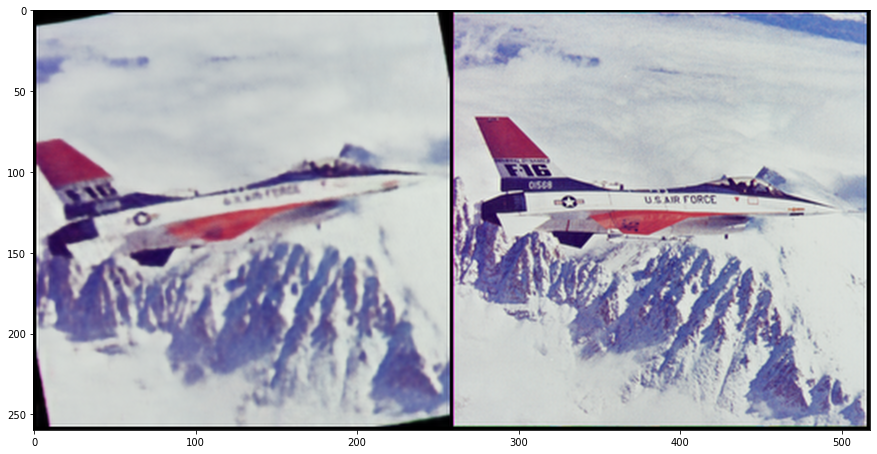

In [77]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);